# HW07: Deep Learning (due 16th November)

In this homework, you will replicate the heterogenous treatment effect exercise from last week's homework using a deep learning model instead of a machine learning one. 

For those who did not complete this exercise, you will investigate the effect of case management on mental health outcomes. These data come from a randomized control trial where patients were assigned to *intensive* or *standard* case management. In this context, the treatment is being assigned to the **intensive** case management while patients assigned to the **standard** case management belong to the control group.

We will investigate characteristics of individuals who are most and least responsive to the treatment, i.e., to being assigned to the intensive case management. 

In [1]:
import pandas as pd
from tensorflow import keras

In [2]:
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta')
df = df.dropna()
pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta', iterator=True).variable_labels()

{'trialid': 'Trial ID',
 'centreid': 'Trial centre',
 'status': 'Patient status at baseline',
 'age': 'Age in years at baseline',
 'sex': 'Sex',
 'afcarib': 'Ethnic group',
 'ocfabth': "Father's social class at birth",
 'chron1l': 'Months since onset of psychosis, logged',
 'hos94': 'Days in hospital for psychiatric reasons: 2 years before baseline',
 'cprs94': 'Psychopathology at baseline (CPRS)',
 'das94': 'Disability at baseline (DAS)',
 'sat94': '(Dis)satisfaction with services at baseline',
 'rand': 'Randomised group',
 'hos96': 'Days in hospital for psychiatric reasons: 2 years after baseline',
 'cprs96': 'Psychopathology at 2 years (CPRS)',
 'sat96': '(Dis)satisfaction with services at 2 years'}

In [3]:
df.head()

,trialid,centreid,status,age,sex,afcarib,ocfabth,chron1l,hos94,cprs94,das94,sat94,rand,hos96,cprs96,sat96
1,107.0,St George's,Out-patient,27.0,male,Other,A,3.178054,80.0,4.0,0.285714,18.0,Intensive case management,27.0,3.0,22.000
2,222005.0,St Mary's,In hospital,41.0,male,Other,D,4.521789,240.0,6.0,0.750000,15.0,Intensive case management,15.0,13.0,9.000
3,222018.0,St Mary's,In hospital,25.0,male,Other,C2,4.094345,48.0,12.0,0.125000,18.0,Intensive case management,263.0,6.0,21.375
5,312015.0,King's,Out-patient,31.0,female,Other,A,4.787492,60.0,28.0,2.375000,20.0,Intensive case management,45.0,19.0,17.000
6,221023.0,St Mary's,In hospital,35.0,male,Afro-Caribbean,C2,4.430817,60.0,25.0,1.571428,24.0,Intensive case management,58.0,27.0,19.125


In [7]:
df['rand'].unique()

['Intensive case management', 'Standard case management']
Categories (2, object): ['Standard case management' < 'Intensive case management']

The treatment variable is $rand$, the post-treatment outcomes are $hos96$, $cprs96$ and $sat96$.

In [4]:
treatvar = 'rand'
df[treatvar].value_counts()

Intensive case management    130
Standard case management     116
Name: rand, dtype: int64

In [5]:
outcomes = ['sat96', 'hos96', 'cprs96']
df[outcomes].describe()

,sat96,hos96,cprs96
count,246.000000,246.000000,246.000000
mean,17.271341,65.500000,17.790587
std,4.723009,104.046722,14.090911
min,9.000000,0.000000,0.000000
25%,14.000000,0.000000,7.000000
50%,17.000000,15.000000,15.000000
75%,20.187500,93.500000,26.000000
max,32.000000,692.000000,71.000000


In addition to these variables we need a set of covariates that we want to use to identify individuals who are most and least responsive to treatment. We also encode categorical covariates and prepare them for the ML model.

In [6]:
#Encoding Categorical covariates and preparing the data for tensorflow
covariates = ['status', 'sex', 'sat94', 'ocfabth', 'hos94', 'das94', 'cprs94', 'age', 'afcarib']
covariates_cat = ['status', 'sex', 'ocfabth', 'afcarib']

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df[covariates_cat] = encoder.fit_transform(df[covariates_cat])
df[covariates] = df[covariates].astype('float32')
df[covariates].head()

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib
1,1.0,1.0,18.0,0.0,80.0,0.285714,4.0,27.0,1.0
2,0.0,1.0,15.0,4.0,240.0,0.750000,6.0,41.0,1.0
3,0.0,1.0,18.0,3.0,48.0,0.125000,12.0,25.0,1.0
5,1.0,0.0,20.0,0.0,60.0,2.375000,28.0,31.0,1.0
6,0.0,1.0,24.0,3.0,60.0,1.571428,25.0,35.0,0.0


In [9]:
from sklearn.model_selection import train_test_split

# Subset the dataset by treatment and control
# Within each sample, create a training, a test and a validation set

df_treat = df.loc[df[treatvar]=='Intensive case management']
df_control = df.loc[df[treatvar]!='Intensive case management']

Xt_train, Xt_test, yt_train, yt_test = train_test_split(df_treat[covariates], df_treat['hos96'], test_size=0.3)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(df_control[covariates], df_control['hos96'], test_size=0.3)

In [10]:
##choose one of the three outcomes to analyze
## build two MLP (multilayer perceptron) models to predict the outcome based on the covariates
## the first model should be trained on the treated sample, while the second on the control

# the two MLP models should have with at least 2 hidden layers, ReLU activation, batch normalization, dropout

model_treat = keras.models.Sequential()

model_treat.add(keras.layers.Dense(30, input_dim = Xt_train.shape[1], activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(0.3))
model_treat.add(keras.layers.Dense(15, activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(0.3))
model_treat.add(keras.layers.Dense(1))

model_treat.summary()

model_control = keras.models.Sequential()

model_control.add(keras.layers.Dense(30, input_dim = Xt_train.shape[1], activation="relu"))
model_control.add(keras.layers.BatchNormalization())
model_control.add(keras.layers.Dropout(0.3))
model_control.add(keras.layers.Dense(15, activation="relu"))
model_control.add(keras.layers.BatchNormalization())
model_control.add(keras.layers.Dropout(0.3))
model_control.add(keras.layers.Dense(1))

model_control.summary()
#TODO

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                300       
                                                                 
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 batch_normalization_1 (Batc  (None, 15)               60        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 15)                0

In [11]:
# compile the models
#TODO
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model_treat.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mean_squared_error"])
model_control.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mean_squared_error"])

In [13]:
# fit separate models on the treatment dataset and control dataset
# use early stopping
#TODO
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=2)

hist_treat = model_treat.fit(Xt_train, yt_train, epochs=8,
                    validation_split=0.2, callbacks=[es])

hist_control = model_control.fit(Xc_train, yc_train, epochs=8,
                    validation_split=0.2, callbacks=[es])

Epoch 1/8
3/3 [==============================] - 0s 43ms/step - loss: 19145.4707 - mean_squared_error: 19145.4707 - val_loss: 10032.6768 - val_mean_squared_error: 10032.6768
Epoch 2/8
3/3 [==============================] - 0s 13ms/step - loss: 19268.9883 - mean_squared_error: 19268.9883 - val_loss: 10089.8125 - val_mean_squared_error: 10089.8125
Epoch 2: early stopping
Epoch 1/8
2/2 [==============================] - 0s 63ms/step - loss: 16473.8457 - mean_squared_error: 16473.8457 - val_loss: 1564.9872 - val_mean_squared_error: 1564.9872
Epoch 2/8
2/2 [==============================] - 0s 24ms/step - loss: 16533.1855 - mean_squared_error: 16533.1855 - val_loss: 1578.0961 - val_mean_squared_error: 1578.0961
Epoch 2: early stopping


In [14]:
##get predicted outcomes using the combined test sets for both models 

test_set = Xt_test.append(Xc_test) 
yhat_treat = model_treat.predict(test_set)
yhat_control = model_control.predict(test_set)

3/3 [==============================] - 0s 4ms/step


In [15]:
##find the three individuals in the test set that are most and least responsive to the treatment
##namely the three individuals for who the treatment effect is larger and those for who it is smaller

test_set['treat_effect'] = yhat_treat - yhat_control
test_set = test_set.sort_values('treat_effect', axis=0)
most_least_treat = test_set[:3].append(test_set[-3:])
most_least_treat

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib,treat_effect
178,1.0,1.0,15.0,4.0,17.0,2.714285,60.0,33.0,1.0,-3.888368
334,0.0,0.0,19.0,4.0,7.0,0.666667,23.0,48.0,1.0,-3.175873
299,1.0,1.0,22.0,3.0,4.0,0.500000,11.0,30.0,1.0,-3.084696
149,0.0,0.0,21.0,3.0,225.0,0.250000,12.0,36.0,0.0,1.461486
260,0.0,1.0,23.0,4.0,330.0,1.500000,17.0,47.0,1.0,2.248613
350,1.0,1.0,14.0,3.0,267.0,1.000000,7.0,25.0,1.0,2.303080


[13:40:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


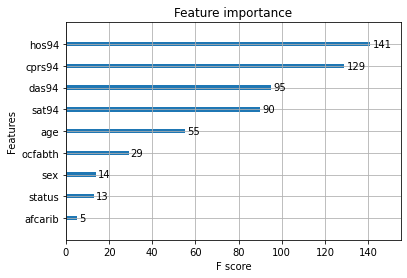

In [17]:
##visualize and comment on the covariates of these individuals
from xgboost import plot_importance
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(test_set[covariates], test_set['treat_effect'])

plot_importance(xgb) 